# COVID-19 mRNA vaccine degregdation prediction using GNN

## 0. Set up

In [1]:
# !pip install dgl dglgo -f https://data.dgl.ai/wheels/repo.html # CPU

In [2]:
# !pip install dgllife

## 1. Download and prepare dataset

We use the [OpenVaccine data hosted on Kaggle](https://www.kaggle.com/competitions/stanford-covid-vaccine/overview).  

In [1]:
!aws s3 cp s3://gnn-in-lifesci-kdd2022/OpenVaccine/ OpenVaccine --recursive

download: s3://gnn-in-lifesci-kdd2022/OpenVaccine/.gitignore to OpenVaccine/.gitignore
download: s3://gnn-in-lifesci-kdd2022/OpenVaccine/test.json to OpenVaccine/test.json
download: s3://gnn-in-lifesci-kdd2022/OpenVaccine/train.json to OpenVaccine/train.json


In [2]:
train_file = 'OpenVaccine/train.json'
test_file = 'OpenVaccine/test.json'

In [3]:
from typing import Tuple, Iterator

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import json
import seaborn as sns
import os
import random
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils import data
from torch.nn import functional as F
from torch.optim import lr_scheduler

import dgl

In [4]:
'''
Utils for parsing the RNA data
'''
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

token_to_idx = {
    'sequence': {x:i for i, x in enumerate('ACGU')}, # residue_to_idx
    'structure': {x:i for i, x in enumerate('().')},
    'predicted_loop_type': {x:i for i, x in enumerate('BEHIMSX')},
}

def get_couples(structure):
    """
    For each closing parenthesis, I find the matching opening one and store their index in the couples list.
    The assigned list is used to keep track of the assigned opening parenthesis
    """
    opened = [idx for idx, i in enumerate(structure) if i == '(']
    closed = [idx for idx, i in enumerate(structure) if i == ')']

    assert len(opened) == len(closed)
    assigned = []
    couples = []

    for close_idx in closed:
        for open_idx in opened:
            if open_idx < close_idx:
                if open_idx not in assigned:
                    candidate = open_idx
            else:
                break
        assigned.append(candidate)
        couples.append([candidate, close_idx])
        
    assert len(couples) == len(opened)
    return couples


def build_edge_list(couples: list, size: int) -> tuple:
    '''
    Build edge list representation of the grap from `couples`, the output 
    of `get_couples`. The output of this function will be used to for 
    constructing dgl graph. 
    '''
    src, dst = [], []
    for i in range(size):
        if i < size - 1:
            # neigbouring bases are linked as well
            src.append(i), 
            dst.append(i + 1)
        if i > 0:
            src.append(i)
            dst.append(i - 1)
    
    for i, j in couples:
        src.extend([i, j])
        dst.extend([j, i])
    
    return src, dst

def row_to_graph(row: pd.Series) -> dgl.DGLGraph:
    '''
    Process a row in the RNA data frame and convert to
    a dgl.DGLGraph object.
    '''
    couples = get_couples(row['structure'])
    edge_list = build_edge_list(couples, len(row['structure']))
    # build a dgl.graph
    g = dgl.graph(edge_list)
    # one-hot encoding for three types of node features
    node_features = []
    for node_feature_col in token_to_idx:
        # for each node, perform categorical encoding 
        node_feature = torch.tensor([token_to_idx[node_feature_col][x] for x in row[node_feature_col]])
        # then convert to one-hot
        node_feature = F.one_hot(node_feature, num_classes=len(token_to_idx[node_feature_col]))
        node_features.append(node_feature)
    node_features = torch.cat(node_features, axis=1)
    # attach as node features 
    g.ndata['h'] = node_features.to(torch.float32)
    return g

In [5]:
class RNADataset(data.Dataset):
    '''mRNA stability prediction dataset'''
    def __init__(self, df, pred_cols=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C'], is_train=True):
        self.df = df
        self.pred_cols = pred_cols
        self.n_outputs = len(pred_cols)
        self.is_train = is_train
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        g = row_to_graph(row)
        
        if self.is_train:
            target = np.array(row[self.pred_cols].values.tolist()).T
            target = torch.tensor(target, dtype=torch.float32) # shape: (n_labeled_nodes, len(pred_cols))

            n_labeled_nodes = target.shape[0]
            n_nodes = g.num_nodes()

            node_labels = torch.zeros([n_nodes, len(self.pred_cols)], dtype=torch.float32)        
            node_labels[:n_labeled_nodes] = target
            g.ndata['target'] = node_labels # shape: (n_nodes, len(pred_cols))

            train_mask = torch.zeros(n_nodes, dtype=torch.bool)
            train_mask[:n_labeled_nodes] = True        
            g.ndata['train_mask'] = train_mask # shape: (n_nodes, )        
        return g

    @property
    def feature_dim(self):
        g = self.__getitem__(0)
        return g.ndata['h'].shape[1]

In [6]:
# parse the data into data frames
train = pd.read_json(train_file, lines=True)
test = pd.read_json(test_file, lines=True)
print(train.shape, test.shape)

(2400, 19) (3634, 7)


In [7]:
train.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')

In [8]:
train.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [9]:
test.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'seq_length', 'seq_scored'],
      dtype='object')

In [10]:
test.head()

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [11]:
train_dataset = RNADataset(train)
test_dataset = RNADataset(test, is_train=False)
print(len(train_dataset), len(test_dataset))

2400 3634


In [12]:
# Look at one RNA graph in the dataset:
i = 0
g = train_dataset[i]
g

Graph(num_nodes=107, num_edges=258,
      ndata_schemes={'h': Scheme(shape=(14,), dtype=torch.float32), 'target': Scheme(shape=(5,), dtype=torch.float32), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [13]:
print('Shape of node features:', g.ndata['h'].shape)
g.ndata['h']

Shape of node features: torch.Size([107, 14])


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [14]:
print('Shape of node targets:', g.ndata['target'].shape)
print('labels:', train_dataset.pred_cols)
g.ndata['target'][:10]

Shape of node targets: torch.Size([107, 5])
labels: ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']


tensor([[0.3297, 0.7556, 2.3375, 0.3581, 0.6382],
        [1.5693, 2.9830, 3.5060, 2.9683, 3.4773],
        [1.1227, 0.2526, 0.3008, 0.2589, 0.9988],
        [0.8686, 1.3789, 1.0108, 1.4552, 1.3228],
        [0.7217, 0.6376, 0.2635, 0.7244, 0.7877],
        [0.4384, 0.3313, 0.3403, 0.4971, 0.5890],
        [0.2560, 0.6763, 0.5617, 0.3819, 0.5231],
        [0.3364, 0.7525, 0.6810, 0.9115, 1.0125],
        [0.2168, 0.2080, 0.0530, 0.1668, 0.0585],
        [0.3583, 0.8908, 0.5348, 1.0613, 0.7349]])

### 1.2. Visualize an individual RNA molecule

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# get the raw features from the data frame:
seq = train.loc[i, 'sequence']
print(seq)
predicted_loop_type = train.loc[i, 'predicted_loop_type']
print(predicted_loop_type)
structure = train.loc[i, 'structure']

# convert to an undirected networkx graph
mol_graph = dgl.to_networkx(g).to_undirected()
print(mol_graph.number_of_nodes(), mol_graph.number_of_edges())

GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUAACUGGAAUAACCCAUACCAGCAGUUAGAGUUCGCUCUAACAAAAGAAACAACAACAACAAC
EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHHHSSSSSSIISSIIIIISSXXXXSSSSSSSHHHHSSSSSSSEEEEEEEEEEEEEEEEEEEEE
107 129


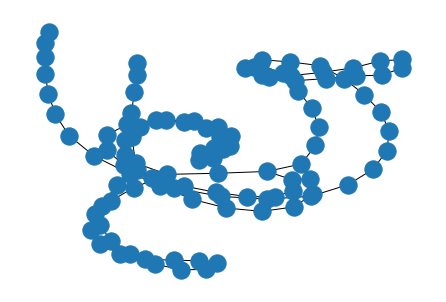

In [17]:
pos = nx.spring_layout(mol_graph)
nx.draw(mol_graph, pos)

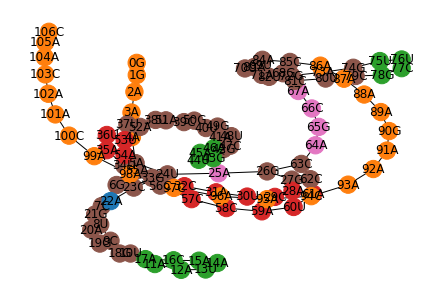

In [18]:
n_residues = mol_graph.number_of_nodes()

# label nodes by the index and residue type
numbered_seq = ['%d%s'%(idx, letter) for idx, letter in zip(range(n_residues), seq)]
node_labels = dict(zip(range(n_residues), numbered_seq))

# color by predicted_loop_type
color_palette = sns.color_palette()
node_colors = [color_palette[token_to_idx['predicted_loop_type'][loop_type]] for loop_type in predicted_loop_type]

nx.draw(mol_graph, pos, 
        labels=node_labels,
        node_color=node_colors
       )

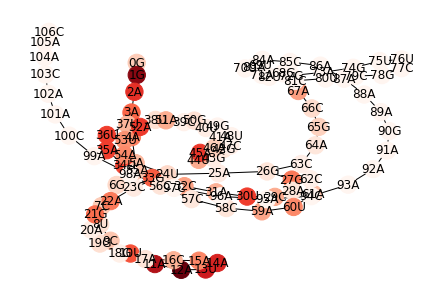

In [19]:
# color by reactivity
reactivities = train.loc[i, 'reactivity'].copy()
# fill 0's for trailing residues
reactivities.extend([0] * (n_residues - len(reactivities)))

nx.draw(mol_graph, pos, 
        labels=node_labels,
        node_color=reactivities,
        cmap='Reds'
       )

## 2. Define a GNN model

In [20]:
from dgllife.model import GCN

RDKit is not installed, which is required for utils related to cheminformatics


In [21]:
model_config = {
    'num_layers': 2,
    'hidden_feats': 8,
    'dropout': 0.2,
    'residual': False,
    'batchnorm': False,
}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

In [22]:
model = GCN(
    in_feats=train_dataset.feature_dim,
    hidden_feats=[model_config['hidden_feats'] for _ in range(model_config['num_layers'] - 1)] + [train_dataset.n_outputs],
    activation=[F.relu for _ in range(model_config['num_layers'] - 1)] + [None],
    residual=[model_config['residual'] for _ in range(model_config['num_layers'])],
    batchnorm=[model_config['batchnorm'] for _ in range(model_config['num_layers'])],
    dropout=[model_config['dropout'] for _ in range(model_config['num_layers'] - 1)] + [0]
).to(device)
model

GCN(
  (gnn_layers): ModuleList(
    (0): GCNLayer(
      (graph_conv): GraphConv(in=14, out=8, normalization=none, activation=<function relu at 0x7effc9a51040>)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): GCNLayer(
      (graph_conv): GraphConv(in=8, out=5, normalization=none, activation=None)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
)

## 3. Train/validation split

In [23]:
train_config = {
    'frac_train': 0.8,
    'lr': 1e-3,
    'n_epochs': 5,
    'batch_size': 128,
    'num_workers': 0,
    'seed': 42
}

N = train.shape[0]
train_idx = np.random.choice(N, int(train_config['frac_train'] * N), replace=False)
valid_idx = np.setdiff1d(np.arange(N), train_idx)
print(train_idx.shape, valid_idx.shape)

(1920,) (480,)


In [24]:
train_dataset = RNADataset(train.iloc[train_idx])
train_loader = data.DataLoader(train_dataset, 
                               batch_size=train_config['batch_size'], 
                               shuffle=True, 
                               pin_memory=True,
                               num_workers=train_config['num_workers'], 
                               collate_fn=dgl.batch
                              )

valid_dataset = RNADataset(train.iloc[valid_idx])
valid_loader = data.DataLoader(valid_dataset, 
                               batch_size=train_config['batch_size'], 
                               shuffle=False, 
                               pin_memory=True,
                               num_workers=train_config['num_workers'], 
                               collate_fn=dgl.batch
                              )

print(len(train_dataset), len(valid_dataset))

1920 480


In [25]:
def train_fn(model, train_loader, criterion, optimizer, device):
    '''Train model for one epoch'''
    model.train()
    model.zero_grad()
    train_loss = []
    
    for index, graphs in enumerate(train_loader):
        graphs = graphs.to(device)
        preds = model(graphs, graphs.ndata['h'])
        train_mask = graphs.ndata['train_mask']
        targets = graphs.ndata['target']
        
        loss = criterion(preds[train_mask], targets[train_mask])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
    
    train_loss_avg = np.mean(train_loss)
    print(f"Train loss {train_loss_avg}")
    return train_loss_avg
    
def eval_fn(model, valid_loader, criterion, device):
    '''Evaluate model'''
    model.eval()
    eval_loss = []
    
    for index, graphs in enumerate(valid_loader):
        graphs = graphs.to(device)
        preds = model(graphs, graphs.ndata['h'])
        train_mask = graphs.ndata['train_mask']
        targets = graphs.ndata['target']
        
        loss = criterion(preds[train_mask], targets[train_mask])
        eval_loss.append(loss.item())
    
    eval_loss_avg = np.mean(eval_loss)
    print(f"Valid loss {eval_loss_avg}")
    return eval_loss_avg


In [26]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=train_config['lr'], weight_decay=0.0)

train_losses = []
eval_losses = []

for epoch in range(train_config['n_epochs']):
    print('#################')
    print('###Epoch:', epoch)

    train_loss = train_fn(model, train_loader, criterion, optimizer, device)
    eval_loss = eval_fn(model, valid_loader, criterion, device)
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)


#################
###Epoch: 0
Train loss 9.80006669362386
Valid loss 7.79948365688324
#################
###Epoch: 1
Train loss 7.688096555074056
Valid loss 6.103569269180298
#################
###Epoch: 2
Train loss 6.117191727956136
Valid loss 4.844751596450806
#################
###Epoch: 3
Train loss 4.937139860788981
Valid loss 3.890866994857788
#################
###Epoch: 4
Train loss 4.033913723627726
Valid loss 3.1569809317588806


## 4. Prediction on hold-out graphs

In [27]:
test_graph = test_dataset[0]
test_graph

Graph(num_nodes=107, num_edges=272,
      ndata_schemes={'h': Scheme(shape=(14,), dtype=torch.float32)}
      edata_schemes={})

In [28]:
model.eval()
predicted_node_labels = model(test_graph.to(device), 
                              test_graph.ndata['h'].to(device))
predicted_node_labels.shape

torch.Size([107, 5])